In [42]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import surprise


In [8]:
df = pd.read_csv("data/movie_ratings_synth.csv",index_col=0)
df

Die Hard  Terminator  Pride and Prejudice  The Notebook  \
User                                                             
User1         5           4                    1             1   
User2         4           5                    2             1   
User3         1           2                    5             4   
User4         1           1                    4             5   

       Mr. & Mrs. Smith  
User                     
User1                 3  
User2                 4  
User3                 3  
User4                 2

In [13]:
#apply NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components=2)
users_vectors= nmf.fit_transform(df)
#put the components into a dataframe
df_components = pd.DataFrame(nmf.components_, columns=df.columns)
df_components

Die Hard  Terminator  Pride and Prejudice  The Notebook  Mr. & Mrs. Smith
0  0.000000    6.436955            48.551993     49.713894         20.475301
1  2.998799    3.002500             0.822832      0.427317          2.275944

# Interpretation
* The first latent variable has high values for romantic movies
* The second latent variable has high values for action movies
* The last movie has high values for both, because it is both a romantic movie and an action movie


In [19]:
users = pd.DataFrame(users_vectors, columns=['d1','d2'], index=df.index)
users

d1        d2
User                     
User1  0.000000  1.458859
User2  0.012786  1.520289
User3  0.086938  0.440969
User4  0.087858  0.200157

# Interpretation
* Users 1 and 2 have high values for d2=> they like action movies
* Users 3 and 4 have high values for d1 => they like romance movies

**Let's check that the reconstructed matrix is close from the original one**

In [21]:
#reconstruct the approximated original matrix
reconstructed = pd.DataFrame(np.dot(users_vectors, df_components), columns=df.columns, index=df.index)
reconstructed

Die Hard  Terminator  Pride and Prejudice  The Notebook  \
User                                                             
User1  4.374823    4.380223             1.200396      0.623396   
User2  4.559041    4.646973             1.871738      1.285297   
User3  1.322376    1.883627             4.583873      4.510477   
User4  0.600231    1.166512             4.430387      4.453305   

       Mr. & Mrs. Smith  
User                     
User1          3.320281  
User2          3.721894  
User3          2.783709  
User4          2.254470

In [23]:
df = pd.read_csv("data/ratings_clean_names.csv")
df.head(2)

userId  rating  movieId   timestamp       title_safe
0    2038     2.0       18  1305046590  Four Rooms(5.0)
1    2858     4.0       18   856639289  Four Rooms(5.0)

In [35]:
print("nb of unique users:", df.userId.nunique())
print("nb of unique movies:", df.movieId.nunique())
print("most viewed movie", df.title_safe.value_counts().index[0], "with", df.title_safe.value_counts()[0], "views")
print("best rated movie", df.groupby("title_safe").mean().sort_values("rating", ascending=False).index[0], "with", df.groupby("title_safe").mean().sort_values("rating", ascending=False).iloc[0,1], "average rating")


nb of unique users: 17906
nb of unique movies: 987
most viewed movie Pulp Fiction(680.0) with 8037 views
best rated movie The Shawshank Redemption(278.0) with 4.464388895867353 average rating


<Axes: xlabel='rating'>

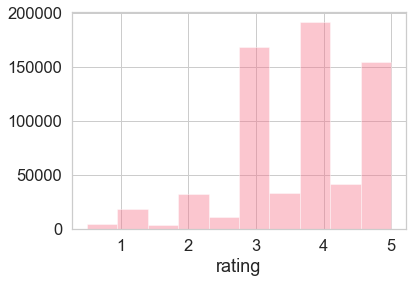

In [41]:
# plot the score distribution with seaborn

sns.distplot(df.rating, kde=False, bins=10)

# Interpretation
We note that the scores
* Are not normally distributed
* Are hihgly skewed towards high scores
* Seem to have large number of exact values (3,4,5) but few decimals (3.5, 4.5)

This means that we need to be cautious when analysing this variable, we cannot treat it as a normal numerical value...

In [43]:
# user Reader to load from the dataframe
reader = surprise.Reader(rating_scale=(0, 5))
data = surprise.Dataset.load_from_df(df[["userId", "movieId", "rating"]], reader)

In [47]:
# use build_full_trainset to build the trainset
trainset = data.build_full_trainset()

# use the SVD algorithm in 2 dimensions
algo = surprise.SVD(n_factors=2)

# train the algorithm on the trainset
algo.fit(trainset)

In [48]:
# get the latent factors for movies in a dataframe, with movie names
movie_factors = pd.DataFrame(algo.qi, columns=["factor1", "factor2"])
movie_factors["title"] = df.title_safe.unique()

In [50]:
# plot as a scatterplot using plotly express
fig = px.scatter(movie_factors, x="factor1", y="factor2", hover_name="title")
fig

In [64]:
algo = surprise.SVD(n_factors=50)
algo.fit(trainset)

#use tsne to reduce the dimensionality to 2
tsne = TSNE(n_components=2)
movie_vectors = tsne.fit_transform(algo.qi)

#put the components into a dataframe
movie_vectors = pd.DataFrame(movie_vectors, columns=["d1", "d2"])
movie_vectors["title"] = df.title_safe.unique()

#plot as a scatterplot using plotly express
fig = px.scatter(movie_vectors, x="d1", y="d2", hover_name="title")
fig


In [59]:
#evaluate the svd algorithm with cross validation
results = surprise.model_selection.cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8717  0.8718  0.8729  0.8713  0.8686  0.8713  0.0014  
MAE (testset)     0.6710  0.6714  0.6732  0.6706  0.6704  0.6713  0.0010  
Fit time          3.41    3.31    3.46    3.32    3.62    3.43    0.11    
Test time         1.26    0.88    1.01    1.22    1.02    1.08    0.14    


In [60]:
results = surprise.model_selection.cross_validate(surprise.SVD(n_factors=2), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8816  0.8813  0.8775  0.8808  0.8773  0.8797  0.0019  
MAE (testset)     0.6798  0.6807  0.6769  0.6784  0.6773  0.6786  0.0014  
Fit time          2.81    3.25    2.93    2.57    2.64    2.84    0.24    
Test time         1.39    1.09    1.41    1.26    0.98    1.22    0.17    


In [61]:
results = surprise.model_selection.cross_validate(surprise.NMF(n_factors=50), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9962  0.9982  0.9908  0.9955  0.9947  0.9951  0.0024  
MAE (testset)     0.7414  0.7423  0.7392  0.7421  0.7408  0.7412  0.0011  
Fit time          11.45   12.46   11.50   11.25   11.51   11.63   0.42    
Test time         0.95    0.94    1.25    1.00    1.16    1.06    0.12    


In [62]:
results = surprise.model_selection.cross_validate(surprise.NMF(n_factors=2), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2413  1.2415  1.2370  1.2410  1.2357  1.2393  0.0025  
MAE (testset)     1.0598  1.0606  1.0559  1.0589  1.0549  1.0580  0.0022  
Fit time          6.57    6.85    6.89    6.90    6.66    6.77    0.14    
Test time         1.20    0.92    1.09    0.75    1.04    1.00    0.15    
